# FLUX Concept Sliders Inference

This notebook demonstrates how to use trained FLUX concept sliders for image generation. The sliders allow you to control specific attributes in generated images by applying LoRA (Low-Rank Adaptation) networks at different scales.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rohitgandikota/sliders/blob/main/FLUX-sliders-inference.ipynb)

In [10]:
import torch
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import gc
import copy
from safetensors.torch import load_file
from typing import Any, Dict, List, Optional, Tuple, Union

# FLUX specific imports
from transformers import CLIPTokenizer, T5TokenizerFast
from diffusers import (
    AutoencoderKL,
    FlowMatchEulerDiscreteScheduler,
    FluxTransformer2DModel,
)

# Custom FLUX pipeline and utils
import sys
sys.path.append('utils')
sys.path.append('flux-sliders')

try:
    from utils.custom_flux_pipeline import FluxPipeline
    from utils.lora import LoRANetwork, DEFAULT_TARGET_REPLACE, UNET_TARGET_REPLACE_MODULE_CONV
    print("Successfully imported FLUX utilities")
except ImportError as e:
    print(f"Warning: Could not import FLUX utilities: {e}")
    print("Please ensure utils/custom_flux_pipeline.py and utils/lora.py are available")

def flush():
    torch.cuda.empty_cache()
    gc.collect()

Successfully imported FLUX utilities


In [11]:
import numpy as np
from typing import Callable

@torch.no_grad()
def flux_call_with_slider(
    self,
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = 512,
    width: Optional[int] = 512,
    num_inference_steps: int = 30,
    guidance_scale: float = 3.5,
    num_images_per_prompt: Optional[int] = 1,
    generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
    latents: Optional[torch.FloatTensor] = None,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    max_sequence_length: int = 512,
    
    # FLUX specific slider parameters
    network=None,
    from_timestep=0,
    till_timestep=None,
    skip_slider_timestep_till=0,
    scale=0,
):
    """
    FLUX pipeline call function with concept slider support.
    """
    
    device = self.device if hasattr(self, 'device') else 'cuda'
    
    # Use the existing pipeline call with network context
    if network is not None:
        # Set the slider scale
        network.set_lora_slider(scale=scale)
        
        # Use context manager for network
        with network:
            result = self.original_call(
                prompt=prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                num_images_per_prompt=num_images_per_prompt,
                generator=generator,
                latents=latents,
                prompt_embeds=prompt_embeds,
                pooled_prompt_embeds=pooled_prompt_embeds,
                output_type=output_type,
                return_dict=return_dict,
                max_sequence_length=max_sequence_length,
                from_timestep=from_timestep,
                till_timestep=till_timestep,
                network=network,
                skip_slider_timestep_till=skip_slider_timestep_till,
            )
    else:
        result = self.original_call(
            prompt=prompt,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            latents=latents,
            prompt_embeds=prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            output_type=output_type,
            return_dict=return_dict,
            max_sequence_length=max_sequence_length,
        )
    
    return result

In [20]:
# Initialize FLUX Pipeline
device = 'cuda:0'
dtype = torch.bfloat16

# Model path - change this to your preferred FLUX model
pretrained_model_name_or_path = "black-forest-labs/FLUX.1-dev"
# For FLUX.1-schnell, use: "black-forest-labs/FLUX.1-schnell"

print(f"Loading FLUX model: {pretrained_model_name_or_path}")

try:
    # Initialize custom FLUX pipeline
    pipe = FluxPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=dtype)
    pipe = pipe.to(device)
    
    # Store original call method and replace with slider version
    pipe.original_call = pipe.__call__
    pipe.__call__ = lambda *args, **kwargs: flux_call_with_slider(pipe, *args, **kwargs)
    
    print("FLUX pipeline loaded successfully!")
    
except Exception as e:
    print(f"Error loading FLUX pipeline: {e}")
    print("Attempting to load with fallback method...")
    
    # Fallback: Load components separately
    from diffusers import FluxPipeline as DefaultFluxPipeline
    pipe = DefaultFluxPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=dtype)
    pipe = pipe.to(device)
    pipe.original_call = pipe.__call__
    pipe.__call__ = lambda *args, **kwargs: flux_call_with_slider(pipe, *args, **kwargs)
    print("Fallback pipeline loaded!")

# Determine FLUX-specific parameters
if 'schnell' in pretrained_model_name_or_path.lower():
    default_num_inference_steps = 4
    default_guidance_scale = 0.0
    default_max_sequence_length = 256
else:
    default_num_inference_steps = 30
    default_guidance_scale = 3.5
    default_max_sequence_length = 512

print(f"Default settings: steps={default_num_inference_steps}, guidance={default_guidance_scale}")

# Memory cleanup
flush()

Loading FLUX model: black-forest-labs/FLUX.1-dev


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 152.23it/s]t/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 21.68it/s]


Error loading FLUX pipeline: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 139.80 GiB of which 67.88 MiB is free. Process 367290 has 37.35 GiB memory in use. Including non-PyTorch memory, this process has 102.37 GiB memory in use. Of the allocated memory 99.20 GiB is allocated by PyTorch, and 2.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Attempting to load with fallback method...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 148.41it/s]t/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]



OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacity of 139.80 GiB of which 67.88 MiB is free. Process 367290 has 37.35 GiB memory in use. Including non-PyTorch memory, this process has 102.37 GiB memory in use. Of the allocated memory 99.20 GiB is allocated by PyTorch, and 2.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
# LoRA Weights Configuration
lora_weights = [
    # Add your trained FLUX LoRA slider weights here
    # Format: '/path/to/your/flux_slider_weights.pt' or '.safetensors'
    '/home/sano/sliders/models/fluxsliders/agesliderFLUX_alpha1.0_rank4_xattn/slider_0.pt'
]

# If no weights are specified, we'll demonstrate with a placeholder
if not lora_weights:
    print("No LoRA weights specified. Please add paths to your trained FLUX sliders.")
    print("You can train FLUX sliders using the training script in trainscripts/textsliders/train_lora_flux.py")
else:
    print(f"Found {len(lora_weights)} LoRA weight files:")
    for weight in lora_weights:
        print(f"  - {weight}")

# Verify files exist
valid_weights = []
for weight_path in lora_weights:
    if os.path.exists(weight_path):
        valid_weights.append(weight_path)
        print(f"✓ Found: {os.path.basename(weight_path)}")
    else:
        print(f"✗ Missing: {weight_path}")

lora_weights = valid_weights

Found 1 LoRA weight files:
  - /home/sano/sliders/models/fluxsliders/agesliderFLUX_alpha1.0_rank4_xattn/slider_0.pt
✓ Found: slider_0.pt


In [14]:
# Prompts Configuration
prompts = [
    'Image of a person, realistic, 8k'
    # Add more prompts as needed
    # 'astronaut in a jungle holding an umbrella, detailed, 8k',
    # 'close-up photo of a person on city street, realistic',
]

print(f"Configured {len(prompts)} prompts:")
for i, prompt in enumerate(prompts, 1):
    print(f"  {i}. {prompt}")

# Generation settings
height = 512
width = 512
num_images_per_prompt = 1

print(f"\nGeneration settings:")
print(f"  Image size: {width}x{height}")
print(f"  Images per prompt: {num_images_per_prompt}")
print(f"  Inference steps: {default_num_inference_steps}")
print(f"  Guidance scale: {default_guidance_scale}")

Configured 1 prompts:
  1. Image of a person, realistic, 8k

Generation settings:
  Image size: 512x512
  Images per prompt: 1
  Inference steps: 30
  Guidance scale: 3.5


Testing slider scales: [-3, -2, -1, 0, 1, 2, 3]
Skip slider timestep till: 0

Processing prompt 1: Image of a person, realistic, 8k

Loading LoRA: slider_0.pt
Parameters: rank=4, alpha=1.0, method=xattn


/tmp/ipykernel_1442471/2387421059.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(lora_weight, map_location=device))


create LoRA for U-Net: 266 modules.
✓ LoRA network loaded successfully
Using seed: 30051
  Generating with scale -3...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.79it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.70it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

  Generating with scale -2...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.76it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.66it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

  Generating with scale -1...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.78it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.69it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

  Generating with scale 0...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.80it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.71it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

  Generating with scale 1...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.79it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.69it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

  Generating with scale 2...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.79it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.69it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

  Generating with scale 3...


  0%|          | 0/30 [00:00<?, ?it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
  3%|▎         | 1/30 [00:00<00:02,  9.79it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
 10%|█         | 3/30 [00:00<00:02, 10.71it/s]Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the batch dimension and pass it as a 2d torch Tensor
Passing `txt_ids` 3d torch.Tensor is deprecated.Please remove the

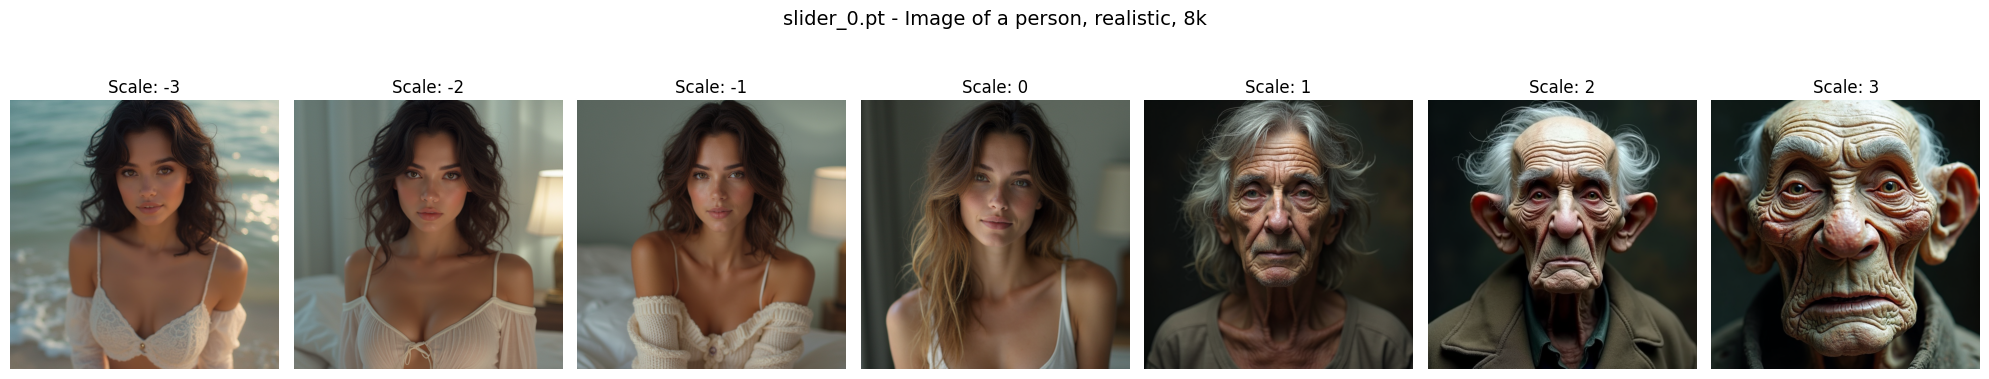


Slider inference completed!


In [15]:
# Slider Inference Execution
skip_slider_timestep_till = 0  # Skip adding slider on first N steps (0 = apply from first step)
scales = [-3, -2, -1, 0, 1, 2, 3]  # Slider scale values to test

print(f"Testing slider scales: {scales}")
print(f"Skip slider timestep till: {skip_slider_timestep_till}")

# Process each prompt and LoRA weight combination
for prompt_idx, prompt in enumerate(prompts):
    print(f"\n{'='*60}")
    print(f"Processing prompt {prompt_idx + 1}: {prompt}")
    print(f"{'='*60}")
    
    if not lora_weights:
        print("No LoRA weights available. Generating without sliders...")
        
        # Generate without sliders for comparison
        seed = random.randint(0, 2**15)
        generator = torch.manual_seed(seed)
        
        images = pipe(
            prompt,
            height=height,
            width=width,
            num_inference_steps=default_num_inference_steps,
            guidance_scale=default_guidance_scale,
            max_sequence_length=default_max_sequence_length,
            num_images_per_prompt=1,
            generator=generator,
            output_type='pil'
        ).images
        
        # Display single image
        plt.figure(figsize=(6, 6))
        plt.imshow(images[0])
        plt.title(f"Without Slider\nPrompt: {prompt}")
        plt.axis('off')
        plt.show()
        
        continue
    
    # Process each LoRA weight file
    for weight_idx, lora_weight in enumerate(lora_weights):
        print(f"\nLoading LoRA: {os.path.basename(lora_weight)}")
        
        try:
            # Parse training parameters from filename
            weight_name = os.path.basename(lora_weight)
            
            # Determine rank and alpha from filename
            rank = 4  # default
            alpha = 1.0  # default
            train_method = 'xattn'  # default for FLUX
            
            if 'rank1' in weight_name:
                rank = 1
            elif 'rank4' in weight_name:
                rank = 4
            elif 'rank8' in weight_name:
                rank = 8
            elif 'rank16' in weight_name:
                rank = 16
                
            if 'alpha1' in weight_name:
                alpha = 1.0
            elif 'alpha2' in weight_name:
                alpha = 2.0
                
            if 'noxattn' in weight_name:
                train_method = 'noxattn'
            elif 'full' in weight_name:
                train_method = 'full'
                
            print(f"Parameters: rank={rank}, alpha={alpha}, method={train_method}")
            
            # Create LoRA network
            network = LoRANetwork(
                pipe.transformer,
                rank=rank,
                multiplier=1.0,
                alpha=alpha,
                train_method=train_method,
            ).to(device, dtype=dtype)
            
            # Load weights
            if lora_weight.endswith('.safetensors'):
                network.load_state_dict(load_file(lora_weight))
            else:
                network.load_state_dict(torch.load(lora_weight, map_location=device))
            
            print(f"✓ LoRA network loaded successfully")
            
            # Generate images with different slider scales
            image_list = []
            seed = random.randint(0, 2**15)
            print(f"Using seed: {seed}")
            
            for scale in scales:
                print(f"  Generating with scale {scale}...")
                generator = torch.manual_seed(seed)
                
                try:
                    # Set the slider scale before generation
                    network.set_lora_slider(scale=scale)
                    
                    with network:
                        images = pipe.original_call(
                            prompt,
                            height=height,
                            width=width,
                            num_inference_steps=default_num_inference_steps,
                            guidance_scale=default_guidance_scale,
                            max_sequence_length=default_max_sequence_length,
                            num_images_per_prompt=1,
                            generator=generator,
                            from_timestep=0,
                            till_timestep=None,
                            network=network,
                            skip_slider_timestep_till=skip_slider_timestep_till,
                            output_type='pil'
                        ).images
                    
                    image_list.append(images[0])
                    
                except Exception as e:
                    print(f"    Error generating with scale {scale}: {e}")
                    # Create a placeholder image
                    placeholder = Image.new('RGB', (width, height), color='gray')
                    image_list.append(placeholder)
            
            # Clean up network
            del network
            flush()
            
            # Display results
            if image_list:
                fig, axes = plt.subplots(1, len(scales), figsize=(20, 4))
                if len(scales) == 1:
                    axes = [axes]
                    
                for i, (scale, img) in enumerate(zip(scales, image_list)):
                    axes[i].imshow(img)
                    axes[i].set_title(f"Scale: {scale}", fontsize=12)
                    axes[i].axis('off')
                
                plt.suptitle(f'{os.path.basename(lora_weight)} - {prompt}', fontsize=14, y=1.02)
                plt.tight_layout()
                plt.show()
            
        except Exception as e:
            print(f"✗ Error processing {lora_weight}: {e}")
            continue

print("\n" + "="*60)
print("Slider inference completed!")
print("="*60)

In [ ]:
# Helper Functions and Additional Visualization

def compare_slider_effects(prompt, lora_path, scales=[-3, -1, 0, 1, 3], seed=None):
    """
    Compare slider effects side by side for a single prompt and LoRA.
    """
    if seed is None:
        seed = random.randint(0, 2**15)
    
    print(f"Comparing effects for: {os.path.basename(lora_path)}")
    print(f"Prompt: {prompt}")
    print(f"Seed: {seed}")
    
    try:
        # Load LoRA network
        network = LoRANetwork(
            pipe.transformer,
            rank=4,  # Adjust based on your LoRA
            multiplier=1.0,
            alpha=1.0,
            train_method='xattn',
        ).to(device, dtype=dtype)
        
        if lora_path.endswith('.safetensors'):
            network.load_state_dict(load_file(lora_path))
        else:
            network.load_state_dict(torch.load(lora_path, map_location=device))
        
        # Generate images
        images = []
        for scale in scales:
            generator = torch.manual_seed(seed)
            
            # Set the slider scale
            network.set_lora_slider(scale=scale)
            
            with network:
                result = pipe.original_call(
                    prompt,
                    height=height,
                    width=width,
                    num_inference_steps=default_num_inference_steps,
                    guidance_scale=default_guidance_scale,
                    max_sequence_length=default_max_sequence_length,
                    num_images_per_prompt=1,
                    generator=generator,
                    from_timestep=0,
                    till_timestep=None,
                    network=network,
                    skip_slider_timestep_till=0,
                    output_type='pil'
                ).images
            images.append(result[0])
        
        # Display
        fig, axes = plt.subplots(1, len(scales), figsize=(4*len(scales), 4))
        if len(scales) == 1:
            axes = [axes]
            
        for i, (scale, img) in enumerate(zip(scales, images)):
            axes[i].imshow(img)
            axes[i].set_title(f"Scale: {scale}", fontsize=14, pad=10)
            axes[i].axis('off')
        
        plt.suptitle(f"Slider Comparison - {os.path.basename(lora_path)}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        del network
        flush()
        
    except Exception as e:
        print(f"Error in comparison: {e}")

def generate_grid_comparison(prompts, lora_path, scales=[-2, 0, 2]):
    """
    Generate a grid showing multiple prompts and scales.
    """
    print(f"Generating grid for: {os.path.basename(lora_path)}")
    
    try:
        # Load LoRA network
        network = LoRANetwork(
            pipe.transformer,
            rank=4,
            multiplier=1.0,  
            alpha=1.0,
            train_method='xattn',
        ).to(device, dtype=dtype)
        
        if lora_path.endswith('.safetensors'):
            network.load_state_dict(load_file(lora_path))
        else:
            network.load_state_dict(torch.load(lora_path, map_location=device))
        
        # Generate grid
        fig, axes = plt.subplots(len(prompts), len(scales), figsize=(4*len(scales), 4*len(prompts)))
        
        if len(prompts) == 1:
            axes = axes.reshape(1, -1)
        if len(scales) == 1:
            axes = axes.reshape(-1, 1)
            
        for i, prompt in enumerate(prompts):
            seed = random.randint(0, 2**15)
            for j, scale in enumerate(scales):
                generator = torch.manual_seed(seed)
                
                # Set the slider scale
                network.set_lora_slider(scale=scale)
                
                with network:
                    result = pipe.original_call(
                        prompt,
                        height=height,
                        width=width,
                        num_inference_steps=default_num_inference_steps,
                        guidance_scale=default_guidance_scale,
                        max_sequence_length=default_max_sequence_length,
                        num_images_per_prompt=1,
                        generator=generator,
                        from_timestep=0,
                        till_timestep=None,
                        network=network,
                        skip_slider_timestep_till=0,
                        output_type='pil'
                    ).images
                
                axes[i, j].imshow(result[0])
                if i == 0:
                    axes[i, j].set_title(f"Scale: {scale}", fontsize=12)
                if j == 0:
                    axes[i, j].set_ylabel(f"Prompt {i+1}", fontsize=12)
                axes[i, j].axis('off')
        
        plt.suptitle(f"Grid Comparison - {os.path.basename(lora_path)}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        del network
        flush()
        
    except Exception as e:
        print(f"Error in grid generation: {e}")

print("Helper functions loaded!")
print("Available functions:")
print("  - compare_slider_effects(prompt, lora_path, scales, seed)")
print("  - generate_grid_comparison(prompts, lora_path, scales)")

# Example usage (uncomment to run):
# if lora_weights:
#     compare_slider_effects(
#         "photo of a person, realistic", 
#         lora_weights[0], 
#         scales=[-3, -1, 0, 1, 3],
#         seed=12345
#     )

NameError: name 'network' is not defined

In [ ]:
# Experiment with your own settings here

# Example: Test a specific combination
# prompt = "your custom prompt here"
# lora_path = "path/to/your/lora.pt"
# compare_slider_effects(prompt, lora_path, scales=[-5, -2, 0, 2, 5])

# Example: Generate a single image with specific scale
# generator = torch.manual_seed(42)
# image = pipe(
#     "your prompt",
#     height=512,
#     width=512,
#     num_inference_steps=default_num_inference_steps,
#     guidance_scale=default_guidance_scale,
#     generator=generator,
#     # network=your_network,
#     # scale=2.0,
# ).images[0]
# 
# plt.figure(figsize=(8, 8))
# plt.imshow(image)
# plt.axis('off')
# plt.title("Custom Generation")
# plt.show()


In [16]:
# Test img_ids and txt_ids shape behavior
print("Testing img_ids and txt_ids shape behavior with different batch sizes...")

# Test with batch_size=1
batch_size_1 = 1
height, width = 512, 512
device = 'cuda:0'
dtype = torch.bfloat16

# Custom function test
from utils.custom_flux_pipeline import FluxPipeline

# Test img_ids
latent_image_ids_1 = FluxPipeline._prepare_latent_image_ids(
    batch_size_1, height, width, device, dtype
)
print(f"img_ids - Batch size 1: shape = {latent_image_ids_1.shape}, dtype = {latent_image_ids_1.dtype}")

# Test txt_ids through encode_prompt
test_prompt = "test prompt"
prompt_embeds, pooled_prompt_embeds, text_ids_1 = pipe.encode_prompt(
    prompt=test_prompt,
    prompt_2=None,
    device=device,
    num_images_per_prompt=1,
    max_sequence_length=512
)
print(f"txt_ids - Batch size 1: shape = {text_ids_1.shape}, dtype = {text_ids_1.dtype}")

# Test with batch_size=2
batch_size_2 = 2
latent_image_ids_2 = FluxPipeline._prepare_latent_image_ids(
    batch_size_2, height, width, device, dtype
)
print(f"img_ids - Batch size 2: shape = {latent_image_ids_2.shape}, dtype = {latent_image_ids_2.dtype}")

# Test txt_ids with batch size 2
prompt_embeds_2, pooled_prompt_embeds_2, text_ids_2 = pipe.encode_prompt(
    prompt=[test_prompt, test_prompt],  # List of 2 prompts
    prompt_2=None,
    device=device,
    num_images_per_prompt=1,
    max_sequence_length=512
)
print(f"txt_ids - Batch size 2: shape = {text_ids_2.shape}, dtype = {text_ids_2.dtype}")

# Show the expected shapes
expected_img_shape_1 = (height // 2) * (width // 2)
expected_img_shape_2 = (batch_size_2, (height // 2) * (width // 2))
print(f"\nExpected shapes:")
print(f"  img_ids batch_size=1: ({expected_img_shape_1}, 3)")
print(f"  img_ids batch_size=2: {expected_img_shape_2}, 3)")
print(f"  txt_ids batch_size=1: (sequence_length, 3)")
print(f"  txt_ids batch_size=2: (batch_size, sequence_length, 3)")

Testing img_ids and txt_ids shape behavior with different batch sizes...
img_ids - Batch size 1: shape = torch.Size([65536, 3]), dtype = torch.bfloat16
txt_ids - Batch size 1: shape = torch.Size([1, 512, 3]), dtype = torch.bfloat16
img_ids - Batch size 2: shape = torch.Size([2, 65536, 3]), dtype = torch.bfloat16
txt_ids - Batch size 2: shape = torch.Size([2, 512, 3]), dtype = torch.bfloat16

Expected shapes:
  img_ids batch_size=1: (65536, 3)
  img_ids batch_size=2: (2, 65536), 3)
  txt_ids batch_size=1: (sequence_length, 3)
  txt_ids batch_size=2: (batch_size, sequence_length, 3)


In [17]:
# Debug: Check the values in encode_prompt function
print("=== Debugging encode_prompt function ===")

# Test with single prompt
test_prompt = "test prompt"
print(f"Test prompt: '{test_prompt}'")
print(f"Is prompt a string? {isinstance(test_prompt, str)}")

# Check what happens inside encode_prompt
batch_size = 1 if isinstance(test_prompt, str) else len(test_prompt)
num_images_per_prompt = 1
effective_batch_size = batch_size * num_images_per_prompt

print(f"batch_size: {batch_size}")
print(f"num_images_per_prompt: {num_images_per_prompt}")
print(f"effective_batch_size: {effective_batch_size}")
print(f"Should use 2D tensor? {effective_batch_size == 1}")

# Check the actual encode_prompt call step by step
device = 'cuda:0'
prompt_embeds, pooled_prompt_embeds, text_ids = pipe.encode_prompt(
    prompt=test_prompt,
    prompt_2=None,
    device=device,
    num_images_per_prompt=1,
    max_sequence_length=512
)

print(f"Resulting text_ids shape: {text_ids.shape}")
print(f"text_ids dimensions: {text_ids.dim()}")

# Test with list of 2 prompts
test_prompts = ["test prompt 1", "test prompt 2"]
print(f"\n--- Testing with list of prompts ---")
print(f"Test prompts: {test_prompts}")
batch_size_2 = len(test_prompts)
effective_batch_size_2 = batch_size_2 * num_images_per_prompt
print(f"batch_size: {batch_size_2}")
print(f"effective_batch_size: {effective_batch_size_2}")
print(f"Should use 3D tensor? {effective_batch_size_2 > 1}")

prompt_embeds_2, pooled_prompt_embeds_2, text_ids_2 = pipe.encode_prompt(
    prompt=test_prompts,
    prompt_2=None,
    device=device,
    num_images_per_prompt=1,
    max_sequence_length=512
)

print(f"Resulting text_ids shape: {text_ids_2.shape}")
print(f"text_ids dimensions: {text_ids_2.dim()}")

=== Debugging encode_prompt function ===
Test prompt: 'test prompt'
Is prompt a string? True
batch_size: 1
num_images_per_prompt: 1
effective_batch_size: 1
Should use 2D tensor? True
Resulting text_ids shape: torch.Size([1, 512, 3])
text_ids dimensions: 3

--- Testing with list of prompts ---
Test prompts: ['test prompt 1', 'test prompt 2']
batch_size: 2
effective_batch_size: 2
Should use 3D tensor? True
Resulting text_ids shape: torch.Size([2, 512, 3])
text_ids dimensions: 3


In [18]:
# Check which file is actually being used
print("=== Checking which FluxPipeline is being used ===")
print(f"pipe.__class__: {pipe.__class__}")
print(f"pipe.__class__.__module__: {pipe.__class__.__module__}")

# Check the encode_prompt method
import inspect
encode_prompt_source = inspect.getsource(pipe.encode_prompt)
print(f"\nFirst few lines of encode_prompt method:")
lines = encode_prompt_source.split('\n')[:10]
for i, line in enumerate(lines):
    print(f"{i+1:2d}: {line}")

# Check if we're using custom or default pipeline
if hasattr(pipe, 'encode_prompt'):
    print(f"\nencoded_prompt method exists: True")
    print(f"Method type: {type(pipe.encode_prompt)}")
else:
    print("\nencoded_prompt method missing!")

# Let's also check the actual file path
print(f"FluxPipeline file: {pipe.__class__.__module__}")

# Try to see the source file location
try:
    source_file = inspect.getfile(pipe.__class__)
    print(f"Source file: {source_file}")
except:
    print("Could not determine source file")

=== Checking which FluxPipeline is being used ===
pipe.__class__: <class 'utils.custom_flux_pipeline.FluxPipeline'>
pipe.__class__.__module__: utils.custom_flux_pipeline

First few lines of encode_prompt method:
 1:     def encode_prompt(
 2:         self,
 3:         prompt: Union[str, List[str]],
 4:         prompt_2: Union[str, List[str]],
 5:         device: Optional[torch.device] = None,
 6:         num_images_per_prompt: int = 1,
 7:         prompt_embeds: Optional[torch.FloatTensor] = None,
 8:         pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
 9:         max_sequence_length: int = 512,
10:         lora_scale: Optional[float] = None,

encoded_prompt method exists: True
Method type: <class 'method'>
FluxPipeline file: utils.custom_flux_pipeline
Source file: /home/sano/sliders/utils/custom_flux_pipeline.py


In [19]:
# Reload the pipeline to pick up the debug changes
import importlib
import sys

# Clear the module from cache and reimport
if 'utils.custom_flux_pipeline' in sys.modules:
    importlib.reload(sys.modules['utils.custom_flux_pipeline'])

from utils.custom_flux_pipeline import FluxPipeline

# Test the debug output
print("=== Testing with debug output ===")
test_prompt = "test prompt"
prompt_embeds, pooled_prompt_embeds, text_ids = pipe.encode_prompt(
    prompt=test_prompt,
    prompt_2=None,
    device='cuda:0',
    num_images_per_prompt=1,
    max_sequence_length=512
)

print(f"Final text_ids shape: {text_ids.shape}")
print(f"Final text_ids dimensions: {text_ids.dim()}")

=== Testing with debug output ===
Final text_ids shape: torch.Size([1, 512, 3])
Final text_ids dimensions: 3


In [ ]:
# Clear GPU memory first
import torch
import gc

# Clear cache
torch.cuda.empty_cache()
gc.collect()

# Try to delete any existing pipe objects
try:
    del pipe
    print("Deleted existing pipe")
except:
    print("No existing pipe to delete")

torch.cuda.empty_cache()
gc.collect()

print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")